In [5]:
!pip install numpy
!pip install pandas
!pip install matplotlib

import sys
import numpy as np
import pandas as pd
from math import sqrt
from matplotlib import pyplot as plt
np.set_printoptions(threshold=sys.maxsize)

data = pd.read_csv('faces.csv')

In [6]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:100].T
Y_dev = data_dev[2]
X_dev = data_dev[4:n]
X_dev = X_dev / 255.

data_train = data[1000:1500].T
Y_train = data_train[2]
X_train = data_train[4:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [7]:
print(X_train.shape)
print(_)
side_length = int(sqrt(_))
print(side_length)

(2304, 500)
2304
48


In [8]:
def visualize(image):
    side_length = int(np.sqrt(image.shape[0]))
    current_image = image.reshape((side_length, side_length)) * 255
    current_image = np.asarray(current_image, dtype = np.float64)
    plt.gray()
    plt.imshow(X=current_image, interpolation='nearest', cmap='gray')
    plt.show()

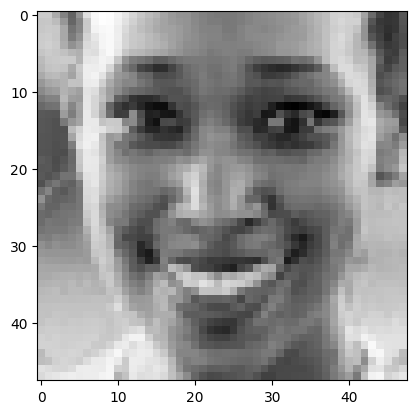

In [19]:
visualize(X_train.T[21])

Layers:
2304 node input layer
4 correlational layers, each 2025 nodes 

In [10]:
edge_detecting_kernels = [
    np.array([[1, -1, -1],
              [0, 1, -1],
              [0, 0, 1]]),
    
    np.array([[-1, -1, 1],
              [-1, 1, 0],
              [1, 0, 0]]),
    
    np.array([[-1, -1, -1],
              [1, 1, 1],
              [0, 0, 0]]),
    
    np.array([[0, 1, -1],
              [0, 1, -1],
              [0, 1, -1]])
]

# currently not being used for processing reasons
def rotate_180_degrees(kernel): # used to go from correlation to convolution!
    new_matrix = np.zeros((3,3), dtype=int)
    for i in range(3):
        for j in range(3):
            new_matrix[i, j] = kernel[2-i, 2-j]
    return new_matrix

In [29]:
# I will need to reduce the size of the images due to processing constraints
def reduce(image):
    new_image = np.array([])
    
    kernel_side_length = 3
    pixel_step = 3
    image_side_length = int(sqrt(image.shape[0])) # assuming image is square, just take sqrt of total pixels
    
    for i in range(image_side_length, step=pixel_step):
        for j in range(image_side_length, step=pixel_step):
            
            reduced_value = 0
            
            
            new_image = np.append(new_image, reduced_value)
            
    return new_image

def correlate(index):
    left_diagonal_image = np.array([])
    right_diagonal_image = np.array([])
    horizontal_image = np.array([])
    vertical_image = np.array([])
    
    current_image = X_train.T[index]
    for i in range(side_length - 3): # 48 pixels per row - 3 to get last area checked by kernal
        for j in range(side_length - 3):
            checked_area = np.array([current_image[i * side_length + j:i * side_length + j + 3],
                                     current_image[(i + 1) * side_length + j:(i + 1) * side_length + j + 3],
                                     current_image[(i + 2) * side_length + j:(i + 2) * side_length + j + 3]])
            sum = [0, 0, 0, 0] # used to store temp pixel values for edge detection maps
            for k in range(3):
                for l in range(3):
                    for m in range(4):
                        sum[m] += checked_area[k, l] * edge_detecting_kernels[m][k, l] / 3
                        
            left_diagonal_image = np.append(left_diagonal_image, sum[0])
            right_diagonal_image = np.append(right_diagonal_image, sum[1])
            horizontal_image = np.append(horizontal_image, sum[2])
            vertical_image = np.append(vertical_image, sum[3])
            
            
    visualize(left_diagonal_image)
    visualize(right_diagonal_image)
    visualize(left_diagonal_image)
    visualize(horizontal_image)
    
    full_edge_image = np.append(left_diagonal_image.flatten(), right_diagonal_image.flatten())
    full_edge_image = np.append(full_edge_image, horizontal_image.flatten())
    full_edge_image = np.append(full_edge_image, vertical_image.flatten())
    return full_edge_image
    
print(correlations.shape)

(8100,)


In [30]:
reduce(X_train.T[21])

48


array([], dtype=float64)